In [ ]:
# percentage correct?
# distance change?
# 200 day by day change?
# decoding improvement over time (familiarity suppression)?
# embeddings, manifold analysis on local population
# check vae and vgg embeddings?
# response sparsity net?

In [3]:
import torch
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan', model_name='biggan-deep-256')

Loading BigGAN model biggan-deep-256 from cache at C:\Users\14470\.pytorch_pretrained_biggan\e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


In [22]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from modeling.models.bethge import BethgeModel
from modeling.train_utils import array_to_dataloader
from PIL import Image
from scipy.stats import spearmanr
from scripts.visualize_SharedCore import visualize_neuron
from scipy import optimize
import os
from torchvision.transforms.functional import to_pil_image
from PIL import ImageOps
import cv2

In [46]:
y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
z = G.sample_latent(batch_size=1)
x = G(z=z, y=y)
#x = x.detach().cpu().numpy()
x = to_pil_image((x[0]+1)/2)

In [47]:
x = ImageOps.grayscale(x)
x.show()

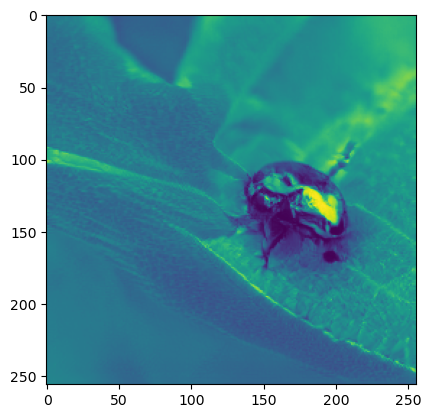

In [30]:

plt.imshow(x)
#gray_image = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

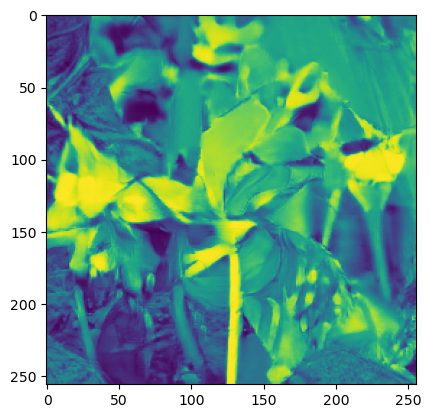

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


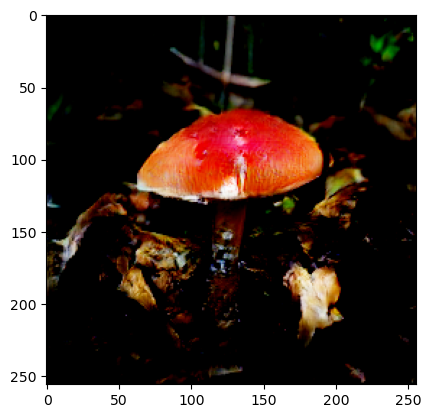

In [3]:
site = 'm2s1'
nb_validation_samples = 1000
nb_training_samples = 49000

batch_size = 2048

train_y = np.load('D:/school/research/CNN_Tang_project/data/Processed_Tang_data/all_sites_data_prepared/New_response_data/trainRsp_'+site+'.npy')
num_neurons = train_y.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

channels = 256
num_layers = 9
input_size = 50
output_size = num_neurons
first_k = 9
later_k = 3
pool_size = 2
factorized = True

num_maps = 1

net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                  output_size=output_size, first_k=first_k, later_k=later_k,
                  input_channels=1, pool_size=pool_size, factorized=True,
                  num_maps=num_maps).cuda()

net.to(device)
net.load_state_dict(torch.load(f'D:/school/research/CNN_Tang_project/saved_models/new_learned_models/{site}_9_model_version_0'))
val_x = np.load('../data/Processed_Tang_data/all_sites_data_prepared/pics_data/val_img_' + site + '.npy')
val_x = np.transpose(val_x, (0, 3, 1, 2))
val_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/valRsp_' + site + '.npy')
num_neurons = val_y.shape[1]
val_loader = array_to_dataloader(val_x, val_y, batch_size=200)
prediction = []
actual = []
for batch_num, (x, y) in enumerate(tqdm(val_loader)):
    x, y = x.to(device), y.to(device)
    outputs = net(x).detach().cpu().numpy()
    prediction.extend(outputs)
    actual.extend(y.detach().cpu().numpy())

prediction = np.stack(prediction)
actual = np.stack(actual)
train_x = np.load('../data/Processed_Tang_data/all_sites_data_prepared/pics_data/train_img_' + site + '.npy')
train_x = np.transpose(train_x, (0, 3, 1, 2))
train_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/trainRsp_' + site + '.npy')
train_loader = array_to_dataloader(train_x, train_y, batch_size=200)
prediction_train = []
actual_train = []
for batch_num, (x, y) in enumerate(tqdm(train_loader)):
    x, y = x.to(device), y.to(device)
    outputs = net(x).detach().cpu().numpy()
    prediction_train.extend(outputs)
    actual_train.extend(y.detach().cpu().numpy())

prediction_train = np.stack(prediction_train)
actual_train = np.stack(actual_train)
prediction_all = np.concatenate((prediction,prediction_train),axis=0)
actual_all = np.concatenate((actual,actual_train),axis=0)

100%|██████████| 245/245 [00:31<00:00,  7.70it/s]


In [4]:
def make_dir_try(dir):
    try:
        os.makedirs(dir, exist_ok=True)
        print("Directory '%s' created successfully" % dir)
    except OSError as error:
        print("Directory '%s' can not be created" % dir)

In [29]:
#LLE experiment
from sklearn.manifold import LocallyLinearEmbedding
%matplotlib
def LLETransform (num, data, n_components=3, n_neighbors=10, image=False):
    if image:
        data = np.reshape(data[:num], (num, 2500))
    else:
        data = data[:num]
    embedding = LocallyLinearEmbedding(n_components=n_components, method="standard",n_neighbors=n_neighbors)
    prediction_transformed = embedding.fit_transform(data)
    return prediction_transformed

def plotManifold (data, is3D=True):
    if(is3D):
        plt.ion()
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(data[:,0], data[:,1], data[:,2])
        plt.show()
    else:
        fig = plt.figure()
        ax = plt.axes()
        ax.scatter(data[:,0], data[:,1])
        plt.show()

def rspMatchSort(baseRsp, compareRsp):
    rsp_dist = np.zeros((baseRsp.shape[0], compareRsp.shape[0]))
    for real_idx, real in tqdm(enumerate(baseRsp)):
        for pred_idx, pred in enumerate(compareRsp):
            rsp_dist[real_idx, pred_idx] = (np.square(pred - real)).mean()
    rsp_sorted = np.argsort(rsp_dist, axis=1)
    correct_rsp_position = np.zeros(baseRsp.shape[0])
    for i, rsp_list in enumerate(rsp_sorted):
        correct_rsp_position[i] = np.where(rsp_list == i)[0]
    return rsp_sorted, correct_rsp_position

def plotManifoldMatchedSamples(samples, rsp_sorted, transformed_data, matchNum = 10, is3D = True):
    if is3D:
        plt.ion()
        fig = plt.figure()
        ax = plt.axes(projection='3d')
       # ax.scatter(transformed_data[:,0], transformed_data[:,1], transformed_data[:,2], color='green', alpha=0.2,s=1)
        ax.scatter(transformed_data[:1000,0], transformed_data[:1000,1], transformed_data[:1000,2], color='blue', alpha=0.2,s=1)
        for s in samples:
            top_match = rsp_sorted[s, :matchNum]
            top_embedding = transformed_data[top_match]
            ax.scatter(top_embedding[:,0], top_embedding[:,1], top_embedding[:,2], label=str(s))
        plt.legend()
        plt.show()
    else:
        plt.ion()
        fig = plt.figure()
        ax = plt.axes()
        ax.scatter(transformed_data[:,0], transformed_data[:,1], color='gray', alpha=0.2,s=1)
        for s in samples:
            top_match = rsp_sorted[s, :matchNum]
            top_embedding = transformed_data[top_match]
            ax.scatter(top_embedding[:,0], top_embedding[:,1],label=str(s))
        plt.legend()
        plt.show()

def saveMatchedImgs(name, rsp_sorted, correct_rsp_position):
    directory = f'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/{site}_{name}'
    make_dir_try(directory)
    all_x = np.concatenate((val_x,train_x),axis=0)
    for i, position in enumerate(correct_rsp_position):
        sample_dir = directory + f'/sample{i}_position{position}'
        make_dir_try(sample_dir)
        top_5_match = rsp_sorted[i, :10]
        top_5_img = all_x[top_5_match]
        for img_idx, img in enumerate(top_5_img):
            img = np.reshape(img, (50,50))
            plt.imsave(sample_dir + f'/ranked{img_idx}_valNum{top_5_match[img_idx]}.png', img, cmap='gray')

Using matplotlib backend: QtAgg


In [31]:
actual_transformed = LLETransform(1000,actual_all,n_neighbors=10)
plotManifold(actual_transformed)
#actual_transformed2d = LLETransform(1000,actual_all,n_neighbors=10,n_components=2)

In [18]:
np.save("all_actual_transformed",actual_transformed)

In [34]:
prediction_transformed = LLETransform(1000,prediction_all,n_neighbors=10)


In [36]:
plotManifold(prediction_transformed)

In [42]:
rsp_sorted, correct_rsp_position = rspMatchSort(actual_transformed[:1000], prediction_transformed[:1000])
#rsp_sorted_r, correct_rsp_position_r = rspMatchSort(actual_transformed[:1000], actual_transformed[:1000])
#rsp_sorted, correct_rsp_position = rspMatchSort(actual, prediction_all[:1000])
#rsp_sorted_r, correct_rsp_position_r = rspMatchSort(actual, actual_all[:1000])

1000it [00:03, 274.28it/s]


In [33]:
saveMatchedImgs("LLEspaceR_Val", rsp_sorted_r, correct_rsp_position_r)

Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspaceR_Val' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspaceR_Val/sample0_position0.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspaceR_Val/sample1_position0.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspaceR_Val/sample2_position0.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspaceR_Val/sample3_position0.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspaceR_Val/sample4_position0.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspaceR_Va

In [43]:
saveMatchedImgs("LLEspace_val", rsp_sorted, correct_rsp_position)

Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspace_val' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspace_val/sample0_position565.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspace_val/sample1_position39.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspace_val/sample2_position10.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspace_val/sample3_position409.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspace_val/sample4_position942.0' created successfully
Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_LLEspace_v

In [41]:
plotManifoldMatchedSamples([9,234,7,116,386,423,807], rsp_sorted,prediction_transformed)
plotManifoldMatchedSamples([9,234,7,116,386,423,807], rsp_sorted_r,actual_transformed)
#plotManifoldMatchedSamples([9,234,7,116,386,423,807], rsp_sorted,prediction_transformed2d,is3D=False)
#plotManifoldMatchedSamples([9,234,7,116,386,423,807], rsp_sorted_r,actual_transformed2d,is3D=False)

In [22]:
images_transformed = LLETransform(10000, np.concatenate((val_x,train_x),axis=0),image=True)

KeyboardInterrupt: 

In [ ]:
images_transformed2d = LLETransform(10000, np.concatenate((val_x,train_x),axis=0),image=True,n_components=2)

In [16]:
plotManifold(images_transformed)
plotManifoldMatchedSamples([9,234,7,116,386,423,807,468], rsp_sorted,images_transformed)
plotManifoldMatchedSamples([9,234,7,116,386,423,807,468], rsp_sorted_r,images_transformed)


In [18]:
plotManifoldMatchedSamples([9,116], rsp_sorted,images_transformed)
plotManifoldMatchedSamples([9,116], rsp_sorted_r,images_transformed)




NameError: name 'images_transformed' is not defined

In [ ]:
plotManifoldMatchedSamples([9,386], rsp_sorted,images_transformed)
plotManifoldMatchedSamples([9,386], rsp_sorted_r,images_transformed)

In [ ]:
plotManifoldMatchedSamples([9,807], rsp_sorted,images_transformed)
plotManifoldMatchedSamples([9,807], rsp_sorted_r,images_transformed)

In [17]:
plotManifoldMatchedSamples([7,807], rsp_sorted,images_transformed)
plotManifoldMatchedSamples([7,807], rsp_sorted_r,images_transformed)

In [94]:
plotManifold(images_transformed,is3D=False)
plotManifoldMatchedSamples([9,234,7,116,386,423,807,468], rsp_sorted,images_transformed,is3D=False)
plotManifoldMatchedSamples([9,234,7,116,386,423,807,468], rsp_sorted_r,images_transformed,is3D=False)

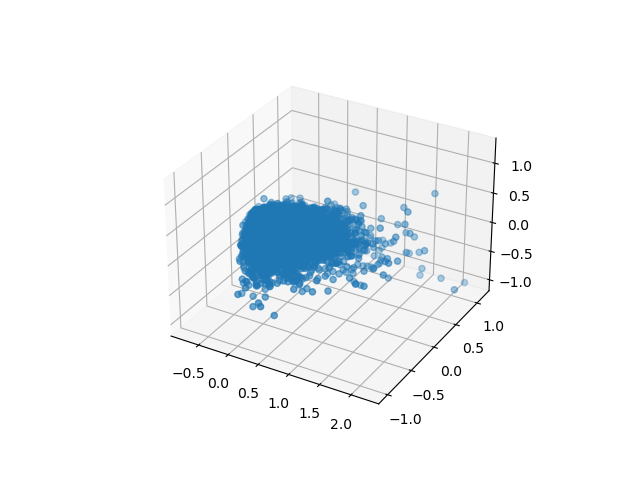

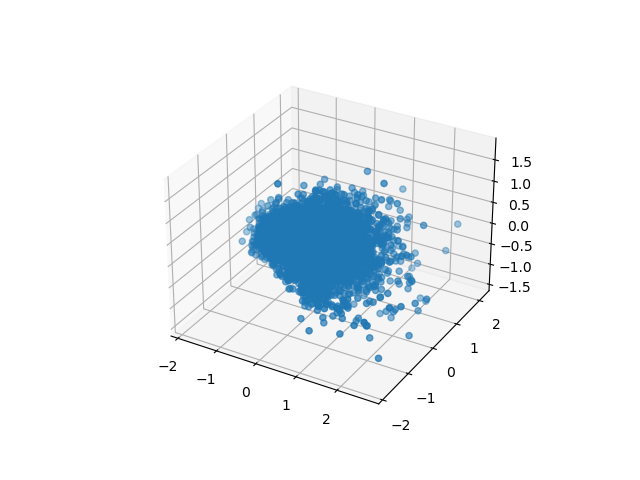

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
predictionPCA = pca.fit_transform(prediction_all[:5000])
actualPCA = pca.fit_transform(actual_all[:5000])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(predictionPCA[:,0], predictionPCA[:,1], predictionPCA[:,2])
figr = plt.figure()
axr = plt.axes(projection='3d')
axr.scatter3D(actualPCA[:,0], actualPCA[:,1], actualPCA[:,2]);

In [ ]:
from sklearn.manifold import TSNE

p_embedded = TSNE(n_components=3, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(prediction_all[:5000])
a_embedded = TSNE(n_components=3, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(actual_all[:5000])

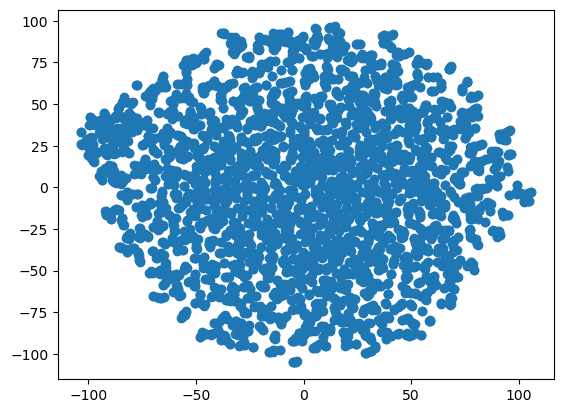

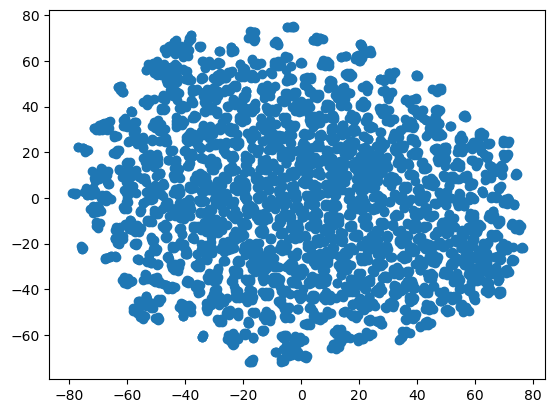

In [43]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(p_embedded[:,0], p_embedded[:,1])
fig = plt.figure()
ax = plt.axes()
ax.scatter(a_embedded[:,0], a_embedded[:,1])

In [ ]:
#sanity test: use all real rsp

In [39]:
rsp_dist_real = np.zeros((1000, 10000))
for real_idx, real in enumerate(actual):
    for pred_idx, pred in enumerate(actual_all[:10000]):
        rsp_dist_real[real_idx, pred_idx] = (np.square(pred - real)).mean()

rsp_sorted_real = np.argsort(rsp_dist_real, axis=1)

correct_rsp_position = np.zeros(1000)
for i, rsp_list in enumerate(rsp_sorted_real):
    correct_rsp_position[i] = np.where(rsp_list == i)[0]

In [ ]:
directory = f'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/{site}_real_10k'
make_dir_try(directory)
for i in range(1000):
    sample_dir = directory + f'/sample{i}'
    make_dir_try(sample_dir)
    top_5_match = rsp_sorted_real[i, :10]
    top_5_img = all_x[top_5_match]
    for img_idx, img in enumerate(top_5_img):
        img = np.reshape(img, (50,50))
        plt.imsave(sample_dir + f'/ranked{img_idx}_valNum{top_5_match[img_idx]}.png', img, cmap='gray')

In [22]:
#metrics
from torchmetrics import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure(reduction='none').to(device)
score = torch.zeros((1000,1000))
for i, position in tqdm(enumerate(correct_rsp_position)):
    top_match = rsp_sorted[i,:1000]
    top_img = all_x[top_match]
    correct_img = all_x[int(position)]

    score[i] = (ssim(torch.tensor(top_img).to(device),torch.tensor([correct_img for i in range(1000)]).to(device)))

score = score.detach().cpu().numpy()

1000it [04:23,  3.79it/s]


In [35]:
#metrics
top_number = 10
mse_score = np.zeros((1000,10))
for i, position in tqdm(enumerate(correct_rsp_position)):
    top_match = rsp_sorted[i,:top_number]
    top_img = np.reshape(all_x[top_match],(top_number,2500))
    correct_img = np.reshape(all_x[int(position)],2500)
    correct_img_matrix = np.array([correct_img for i in range(top_number)])
    mse_score[i] = (np.square(correct_img_matrix - top_img)).mean(axis=1)


1000it [00:00, 11237.85it/s]


In [38]:
#metrics
top_number = 10
corr_score = np.zeros((1000,10))
for i, position in tqdm(enumerate(correct_rsp_position)):
    top_match = rsp_sorted[i,:top_number]
    top_img = np.reshape(all_x[top_match],(top_number,2500))
    correct_img = np.reshape(all_x[int(position)],2500)
    for j, img in enumerate(top_img):
        corr_score[i,j] = np.corrcoef([img, correct_img])[0,1]


1000it [00:00, 1140.95it/s]


In [45]:
from torchvision import transforms, models
class Img2VecResnet18():
    def __init__(self):

        self.device = torch.device("cuda")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()

        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):

        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512

        return cnnModel, layer


# generate vectors for all the images in the set
img2vec = Img2VecResnet18()


score = torch.zeros((1000,1000))
for i, position in tqdm(enumerate(correct_rsp_position)):
    top_match = rsp_sorted[i,:1000]
    top_img = all_x[top_match][0]
    correct_img = all_x[int(position)]
    for img in top_img:
        img_embedding = img2vec.getVec(img)
        print(x)


0it [00:00, ?it/s]


RuntimeError: output with shape [1, 50, 50] doesn't match the broadcast shape [3, 50, 50]

In [37]:

directory = f'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/{site}_SSIM'
make_dir_try(directory)
for i, s in enumerate(score):
    plt.figure()
    plt.plot(s[:10])
    plt.savefig(directory+f'/SSIM_image_{i}')
    plt.close()

Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_SSIM' created successfully


In [ ]:

directory = f'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/{site}_MSE'
make_dir_try(directory)
for i, s in enumerate(mse_score):
    plt.figure()
    _ = plt.plot(s)
    plt.savefig(directory+f'/SSIM_image_{i}')

In [39]:
directory = f'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/{site}_corr'
make_dir_try(directory)
for i, s in enumerate(corr_score):
    plt.figure()
    plt.plot(s)
    plt.savefig(directory+f'/corr_image_{i}')
    plt.close()

Directory 'D:/school/research/CNN_Tang_project/analysis/Reconstruction/match_recon_results/m2s1_corr' created successfully
